**Deep Learning**

**Practice 3.1 - Wasserstein GAN with Gradient Penalty (WGAN-GP)**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
import numpy as np
import glob, os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from skimage.transform import resize




In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [21]:
IMAGE_SIZE = 64
CHANNELS = 3

BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 128


EPOCHS = 100
STEPS_PER_EPOCH=1500


LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 2. Dataset

In this section we load the dataset for training and validation with the provided functions. </br>

Load the images

In [22]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
# Repeat the dataset
train_data = train_data.repeat()

Found 202599 files belonging to 1 classes.


In [23]:
# Preprocess the data
# with this normalization we are converting the pixels values to a range between -1 and 1, it could better than normalizing the values between 0 and 1, 
#it helps the model to convergence faster, help to reduce the risk of overfitting => GAN convergence is hard to identify

def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


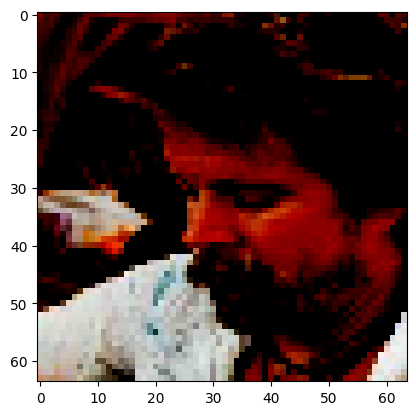

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


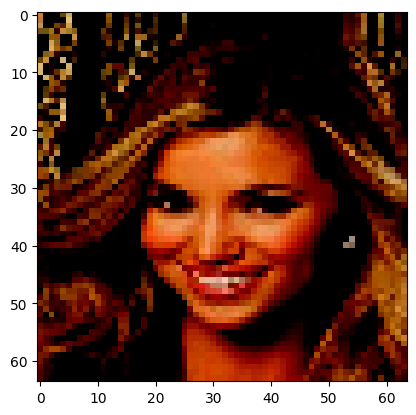

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


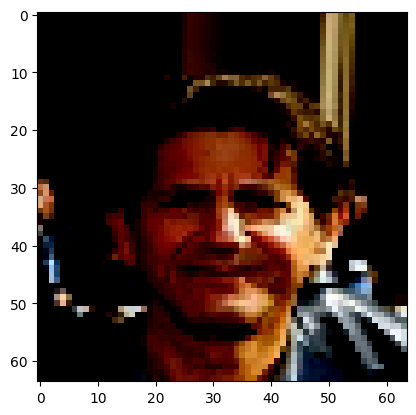

In [24]:
# get the first batch of 64 images
images = next(iter(train.take(1)))
#convert the pixels values to a numpy array so we can show the image
for i in range(0,3):
    image = np.array(images[i])
    print(image.shape)
    # Display the image
    plt.imshow(image)
    plt.show()


## 3. Testing

In this section we experiment with different datasets, optimizers, models, hyperparameters and regularization to define our final model. Each sub section can be enable/disable from the configuration section.

Explanations on the code, model and architecture decision are also included.

### Supplementary functions and default configuration
Supplementary functions to plot the data, return some predefined model, callback and optimizer.

In [25]:
def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()



We should calculate the Ferchet distance for that we need the pre trained model inceptiov3 from keras
- input_shape: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) (with channels_last data format) or (3, 299, 299) (with channels_first data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75. E.g. (150, 150, 3) would be one valid value. input_shape will be ignored if the input_tensor is provided.


In [9]:
model_fid = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

Hyperparameters to talk about: </br>
**Critic steps:** defines the number of times the discriminator is trained before going back to train the generator </br>

**Steps per epochs:** is the number of batches fed for one epoch. So this number will affect how much images are fed in one epoch. With the batch size and this parameter it could make the model to not see all the images in one epochs. For example if we use 128 as a batch size then normally we should have 1582 batches to process. Si with this large dataset, it depends if we want to make the model to see all the images or not. So an approach could be to limit the number of batches processed and that's to limit the computation cost. </br>

*

Experiment with different hyperparameters values
- image size
- batch size
- learning rate
- number of epochs

### First model: 
IMAGE_SIZE = 32</br>
CHANNELS = 3 </br>

BATCH_SIZE = 128 </br>
NUM_FEATURES = 128</br>
Z_DIM = 128</br>

EPOCHS = 100</br>
STEPS_PER_EPOCH=1500 </br>

LEARNING_RATE = 0.0002 </br>
CRITIC_STEPS = 3 </br>


The first model that we experiment take images of size 32*32 in an RGB scale with three channels one for each color.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_115 (Conv2D)         (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_14 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 256)       0   

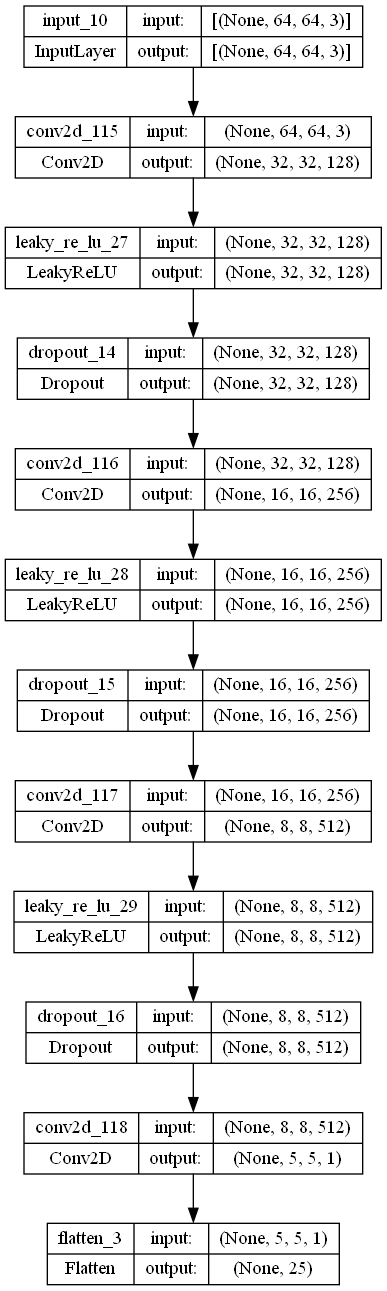

In [45]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
#x = layers.Conv2D(32, kernel_size=4, strides=2, padding="same")(critic_input)
#x = layers.LeakyReLU(0.2)(x)
#x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

tf.keras.utils.plot_model(critic, show_shapes=True)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128)]             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 4, 4, 512)        1048576   
 Transpose)                                                      
                                                                 
 batch_normalization_103 (Ba  (None, 4, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 8, 8, 256)        2097

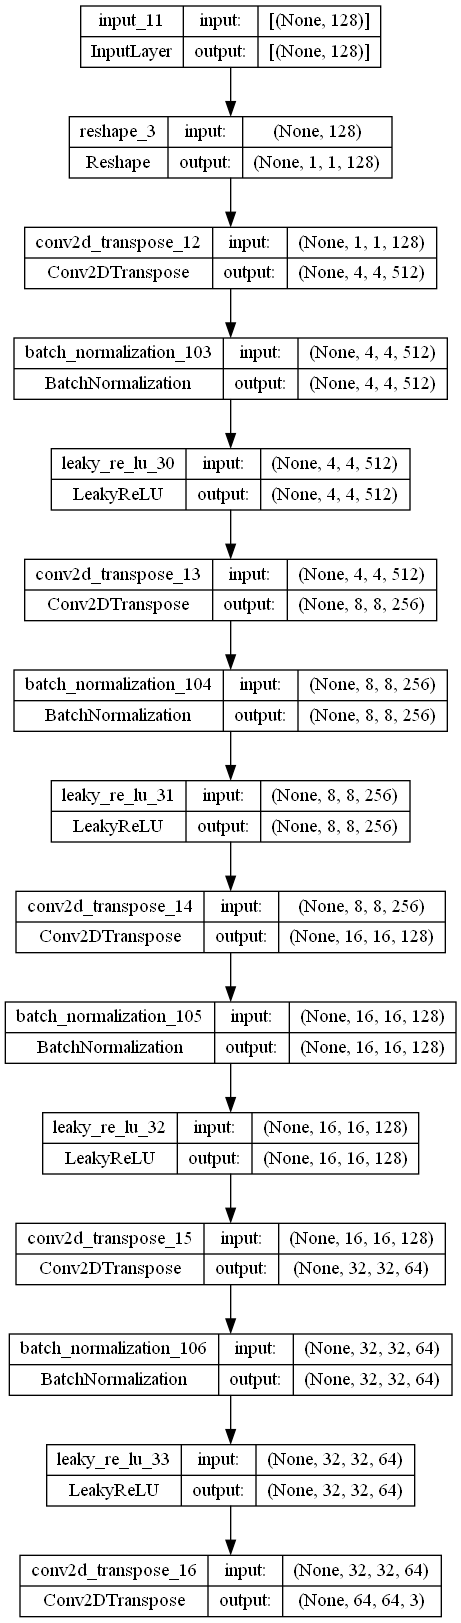

In [46]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
#x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
#x = layers.BatchNormalization(momentum=0.9)(x)
#x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

tf.keras.utils.plot_model(generator, show_shapes=True)


In [47]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp


    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [48]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [49]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [50]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim,interval):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            fig, ax = plt.subplots(nrows=1, ncols=self.num_img, figsize=(10, 2))
            for i in range(self.num_img):
                ax[i].imshow(generated_images[i].astype(int))
                ax[i].axis("off")
            plt.savefig(f"./GAN_output/generated_img_{epoch:03d}.png")
            plt.show()
            plt.close()

In [51]:
class FIDCallback(callbacks.Callback):
    def __init__(self, fid_model, num_img, latent_dim, interval, train_data):
        self.fid_model = fid_model
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.interval = interval
        self.train_data = train_data
        self.fid_values = []
     
    def scale_images(self, images, new_shape):
            images_list = list()
            for image in images:
                # resize with nearest neighbor interpolation
                new_image = resize(image, new_shape, 0)
                # store
                images_list.append(new_image)
            return np.array(images_list)
        
        # calculate frechet inception distance
    def calculate_fid(self,real_images, fake_images):
            # calculate activations
            act1 = self.fid_model.predict(real_images)
            act2 = self.fid_model.predict(fake_images)
            # calculate mean and covariance statistics
            mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
            mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
            # calculate sum squared difference between means
            ssdiff = np.sum((mu1 - mu2)**2.0)
            # calculate sqrt of product between cov
            covmean = sqrtm(sigma1.dot(sigma2))
            # check and correct imaginary numbers from sqrt
            if iscomplexobj(covmean):
                covmean = covmean.real
            # calculate score
            fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
            return fid


    def on_epoch_end(self, epoch ,logs=None):
        if epoch % self.interval == 0: 
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            fake_images = self.model.generator(random_latent_vectors)
            fake_images = fake_images * 127.5 + 127.5
            fake_images = fake_images.numpy()
            # scale images to a fixed size
            fake_images = self.scale_images(fake_images, (299, 299, 3))
            # pre-process images
            fake_images = preprocess_input(fake_images)
            # load real images
            images = next(iter(self.train_data.take(1)))
            real_images=[]
            #convert the pixels values to a numpy array so we can show the image
            for i in range(0,self.num_img):
                real_images.append(images[i])
            # Assume `image_list` is a Python list containing images
            real_images = np.array(real_images)
            real_images = real_images.astype(np.float32)
            # scale real images to a fixed size
            real_images = self.scale_images(real_images, (299, 299, 3))
            # pre-process images
            real_images = preprocess_input(real_images)
            # calculate FID
            fid = self.calculate_fid(real_images, fake_images)
            print('FID : %.3f' % fid)




In [52]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

In [53]:
loss_history = LossHistory()
fid_callback = FIDCallback (fid_model=model_fid, num_img=100, latent_dim=Z_DIM, interval= 10, train_data=train)
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, interval=10), loss_history, fid_callback]
)

Epoch 1/100
  18/1500 [..............................] - ETA: 53:49 - c_loss: -1.2642 - c_wass_loss: -1.4254 - c_gp: 0.0161 - g_loss: 0.2124 - c_acc: 92.7066 - g_acc: 66.1007

KeyboardInterrupt: 

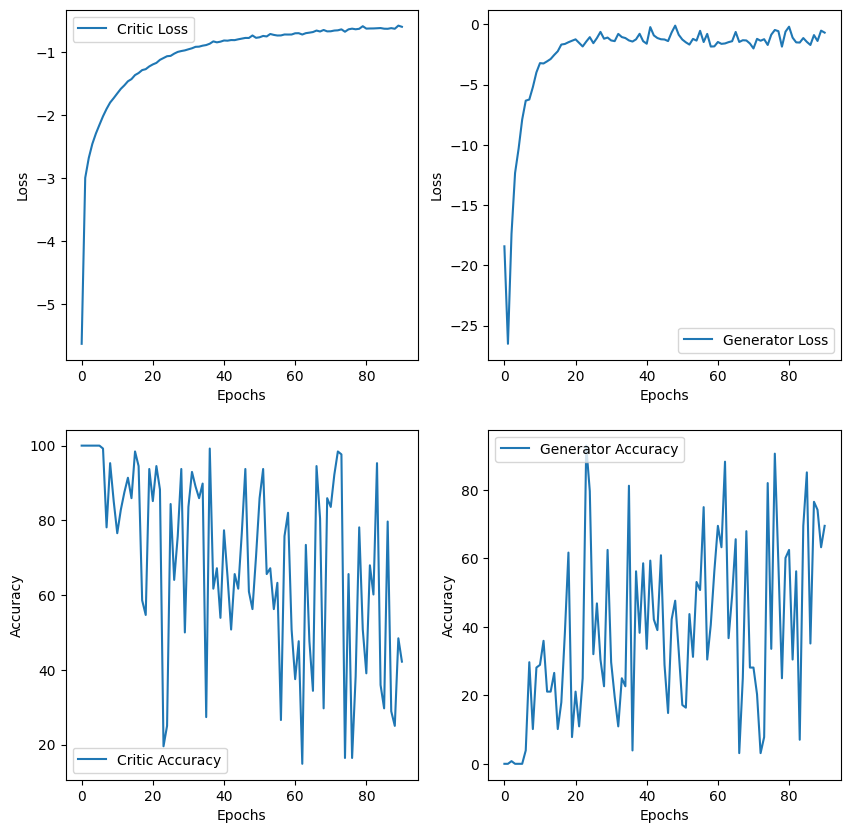

In [47]:
plot_losses_and_accuracy(loss_history)

### Experiments with gray scale images

Hyperparameters to talk about:
*Critic steps: defines the number of times the discriminator is trained before going back to train the generator

*Steps per epochs: is the number of batches fed for one epoch. So this number will affect how much images are fed in one epoch. With the batch size and this parameter it could make the model to not see all the images in one epochs. For example if we use 128 as a batch size then normally we should have 1582 batches to process. Si with this large dataset, it depends if we want to make the model to see all the images or not. So an approach could be to limit the number of batches processed and that's to limit the computation cost.

*

Experiment with different hyperparameters values
- image size
- batch size
- learning rate
- number of epochs

In [52]:
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.array(images_list)

In [ ]:

def calculate_fid(real_images, fake_images):
    # calculate activations
    act1 = model_fid.predict(real_images)
    act2 = model_fid.predict(fake_images)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
images = next(iter(train.take(1)))
real_images=[]
#convert the pixels values to a numpy array so we can show the image
for i in range(0,10):
        print(i)
        real_images.append(images[i])

In [54]:
real_images

[<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[-0.9102941 , -0.8352941 , -0.7982843 ],
         [-0.9377451 , -0.82009804, -0.79656863],
         [-0.9125536 , -0.84833795, -0.805936  ],
         ...,
         [-0.89411765, -0.8392157 , -0.7764706 ],
         [-0.8759804 , -0.8210784 , -0.7583333 ],
         [-0.8745098 , -0.81960785, -0.75686276]],
 
        [[-0.90772825, -0.83272827, -0.79571843],
         [-0.94970894, -0.8320619 , -0.8085325 ],
         [-0.8947687 , -0.830553  , -0.788151  ],
         ...,
         [-0.9115196 , -0.8509804 , -0.8208333 ],
         [-0.92156863, -0.8610294 , -0.8308824 ],
         [-0.92156863, -0.85944396, -0.83405334]],
 
        [[-0.91108304, -0.8308287 , -0.80563724],
         [-0.9223805 , -0.8595512 , -0.81086093],
         [-0.879879  , -0.84850645, -0.7745328 ],
         ...,
         [-0.89485294, -0.83210784, -0.81642157],
         [-0.8980392 , -0.8352941 , -0.81960785],
         [-0.8980392 , -0.8352941 , -0.81960785]

In [57]:

# Assume `image_list` is a Python list containing images
image_array = np.array(real_images)
image_array = image_array.astype(np.float32)


In [59]:
imm = tf.cast(real_images, tf.float32)


In [60]:
s=(299,299,3)
listt = scale_images(imm,s)

TypeError: Cannot interpret 'tf.float32' as a data type